In [ ]:
# Portfolio Construction
!pip install PyPortfolioOpt
!pip install yfinance
!pip install yahoofinancials

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting, objective_functions
from pypfopt.discrete_allocation  import DiscreteAllocation, get_latest_prices
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime as dt
import cvxpy as cp

In [351]:
# Import Investment Universe Price Data for Full Date Range
tickers = ['BABA', 'TSM', 'JD', 'TEVA', 'TCEHY', 'LVMUY', 'ASML', 'AZN', 'RY',
           'VCISY', 'SAP', 'CMWAY', 'SONY', 'DEO', 'NVO', 'SNY', 'KYCCF', 'UL',
           'RIO', 'CSLLY', 'SFTBY', 'BTI', 'VALE', 'NPSNY', 'EADSY', 'AIQUY',
           'BNS', 'DDAIF', 'ENLAY', 'ADDYY', 'BAM', 'IBDRY', 'BHP', 'DTEGY', 
           'MUFG', 'PPRUY', 'CNI', 'BMO', 'TOELY', 'BAYRY', 'ABB', 'LZAGY',
           'DKILY', 'HMC', 'NTDOY', 'RELX', 'UBS', 'GLNCY', 'BUD', 'NJDCY', 'KDDIY',
           'HOCPY', 'ING', 'TAK', 'IFNNY', 'AXAHY', 'RBGLY', 'PUK', 'TRP', 'MRAAY', 
           'DNL', 'DRW', 'BOND', 'TLT', 'BND', 'TIP', 'PHG', 'ATLKY', 'SBRCY', 'FANUY',
           'HESAY', 'GVDNY', 'PDRDY', 'ISNPY', 'SAFRY', 'NGG', 'VOD', 'DANOY']
ohlc = yf.download(tickers, period="7y")
prices = ohlc['Adj Close']
# prices = prices.fillna(0)
prices = prices.loc['2015-01-01':]
vol = 0.12

[*********************100%***********************]  78 of 78 completed


In [352]:
# Slice into quarterly prices
initial = prices.loc['2015-01-01':'2016-01-01']
q2y1 = prices.loc['2016-01-02':'2016-04-01']
q3y1 = prices.loc['2016-04-02':'2016-07-01']
q4y1 = prices.loc['2016-07-02':'2016-10-01']
q1y2 = prices.loc['2016-10-02':'2017-01-01']
q2y2 = prices.loc['2017-01-02':'2017-04-01']
q3y2 = prices.loc['2017-04-02':'2017-07-01']
q4y2 = prices.loc['2017-07-02':'2017-10-01']
q1y3 = prices.loc['2017-10-02':'2018-01-01']
q2y3 = prices.loc['2018-01-02':'2018-04-01']
q3y3 = prices.loc['2018-04-02':'2018-07-01']
q4y3 = prices.loc['2018-07-02':'2018-10-01']
q1y4 = prices.loc['2018-10-02':'2019-01-01']
q2y4 = prices.loc['2019-01-02':'2019-04-01']
q3y4 = prices.loc['2019-04-02':'2019-07-01']
q4y4 = prices.loc['2019-07-02':'2019-10-01']
q1y5 = prices.loc['2019-10-02':'2020-01-01']
q2y5 = prices.loc['2020-01-02':'2020-04-01']
q3y5 = prices.loc['2020-04-02':'2020-07-01']
q4y5 = prices.loc['2020-07-02':'2020-10-01']
q1y6 = prices.loc['2020-10-02':'2021-01-01']
q2y6 = prices.loc['2021-01-02':'2021-04-01']
q3y6 = prices.loc['2021-04-02':'2021-07-01']

quarterly_prices = []
quarterly_prices.append([q2y1, q3y1, q4y1, q1y2, q2y2, q3y2, q4y2, q1y3, 
                         q2y3, q3y3, q4y3, q1y4, q2y4, q3y4, q4y5, q1y5, q2y5, 
                         q3y5, q4y5, q1y6, q2y6, q3y6])

In [353]:
# Initial weights using runup period before portolio initialisation 
weights_series = []

mu = expected_returns.mean_historical_return(initial)
S = risk_models.semicovariance(initial)

initial_weights = np.array([1/len(initial.columns)] * len(initial.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
ef.portfolio_performance(verbose=True);
weights_series.append(weights)

Expected annual return: 26.6%
Annual volatility: 12.0%
Sharpe Ratio: 2.05


In [354]:
# Initial Capital = $10,000,000, broker transaction fees = 
initial_capital = 10000000


In [355]:
# Function to return number of shares
def new_positions(df, weights, initial_capital):
  initial_buy = (np.array(list(weights.values())) * initial_capital / df.iloc[-1])
  initial_buy = [math.floor(a) for a in initial_buy]
  holdings_dict = dict(zip(weights.keys(), initial_buy))
  return holdings_dict

In [347]:
q3y1

,ABB,ADDYY,AIQUY,ASML,ATLKY,AXAHY,AZN,BABA,BAM,BAYRY,BHP,BMO,BND,BNS,BOND,BTI,BUD,CAD=X,CHF=X,CMWAY,CNI,CSLLY,DANOY,DDAIF,DEO,DKILY,DNL,DRW,DTEGY,EADSY,ENLAY,EUR=X,FANUY,GBP=X,GLNCY,GVDNY,HESAY,HMC,HOCPY,IBDRY,...,JD,JPY=X,KDDIY,KYCCF,LVMUY,LZAGY,MRAAY,MUFG,NGG,NJDCY,NPSNY,NTDOY,NVO,PDRDY,PHG,PPRUY,PUK,RBGLY,RELX,RIO,RY,SAFRY,SAP,SBRCY,SFTBY,SNY,SONY,TAK,TCEHY,TEVA,TIP,TLT,TOELY,TRP,TSM,UBS,UL,VALE,VCISY,VOD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-04,15.543870,55.305515,16.919888,95.872032,16.673864,16.968925,23.644650,79.080002,19.843231,23.536249,19.329258,49.527725,71.695969,37.237896,89.507690,43.255611,108.794449,1.30360,0.95860,43.866257,57.293137,36.063927,11.771367,57.491108,94.199791,7.2905,20.601162,19.907711,14.812711,14.827546,3.375138,0.87796,14.994,0.70301,3.591329,35.449272,NaN,26.170000,38.200001,20.923010,...,26.639999,111.722000,13.40,133.542862,30.308117,15.076927,9.566667,4.51,57.909607,8.280,18.967203,17.190001,49.715572,20.045971,24.407007,15.027012,28.078102,16.706093,16.333744,18.183788,46.943604,16.104425,72.754318,4.793053,12.175,33.005047,25.610001,22.500000,20.164206,51.713696,101.597519,116.192810,15.230000,29.403803,21.488245,12.345092,37.923557,3.252750,15.797601,22.872650
2016-04-05,15.303377,54.826637,16.498423,93.881577,16.138132,16.418463,23.421118,77.320000,19.831129,22.849869,18.859152,49.091610,71.825958,36.731102,89.575531,43.196468,106.982941,1.30767,0.95880,42.114113,56.912483,34.922890,11.696017,55.634071,92.743996,NaN,20.329744,19.589956,14.573246,14.553806,3.288997,0.87804,14.640,0.70102,3.411763,35.367653,33.148308,25.629999,37.930000,20.586424,...,26.520000,111.250000,13.09,130.139832,29.644958,14.979598,9.350000,4.33,57.452019,8.060,18.466640,16.930000,49.216190,20.036888,24.000074,14.668210,27.304747,16.585840,16.031744,17.876255,46.245888,15.689556,71.208488,4.713289,12.385,32.555405,25.690001,22.490000,19.681761,51.609619,101.703674,117.463509,15.030000,28.774889,21.205614,11.908167,37.739552,3.308833,15.686472,22.094374
2016-04-06,15.391562,55.793774,16.659344,95.372070,16.184429,16.572592,24.662960,78.680000,19.921875,23.308798,19.047194,49.190350,71.791306,36.894829,89.541603,43.115150,106.439476,1.31412,0.95641,42.640537,57.098164,35.811394,11.804856,55.187160,93.807518,7.3190,20.529972,19.796865,14.795606,14.745423,3.304659,0.87858,14.922,0.70640,3.386111,36.165691,33.148308,26.059999,37.730000,20.742979,...,26.740000,110.377998,13.26,134.496078,29.886921,15.209646,9.583333,4.40,57.697155,8.280,18.764271,17.139999,50.723263,20.109581,24.141617,14.941582,28.300154,16.740446,16.143917,18.039839,46.303349,15.793276,72.434174,4.851063,12.595,33.746555,25.840000,23.180000,20.351274,53.672108,101.438324,116.610428,15.140000,29.201933,21.297054,12.114713,38.333416,3.284797,15.746312,22.584400
2016-04-07,15.215197,54.864197,16.214891,94.419281,15.986011,16.146898,24.530495,77.610001,19.825075,22.811626,18.741625,48.474453,72.025307,36.356853,89.592491,42.885963,104.386452,1.30808,0.95551,41.564125,56.587536,35.362465,11.637410,55.142460,93.275764,7.3190,20.258549,19.516060,14.590349,14.654177,3.226350,0.87681,14.928,0.70731,3.146689,35.902702,32.532494,25.680000,37.689999,20.484669,...,26.510000,109.698997,13.59,136.059326,29.465731,15.200797,9.550000,4.35,57.648140,8.260,18.493700,17.540001,50.143616,19.918758,23.655067,14.514437,27.404287,16.448412,16.057632,17.621067,45.975018,15.463266,70.677963,4.822057,12.715,33.273247,25.299999,23.500000,20.302046,53.454510,101.792107,118.049973,15.320000,29.170870,21.089241,11.876390,38.065754,3.260762,15.677924,22.829414
2016-04-08,15.527839,54.882980,16.375813,94.947556,16.482059,16.616629,24.381475,77.470001,20.079170,23.260492,19.407610,49.601776,71.964622,37.113144,89.702774,43.566113,104.912643,1.31400,0.95610,42.239826,57.608799,35.755280,11.603921,55.142460,93.946991,7.5440,20.596712,19.841202,14.701532,14.845796,3.335983,0.87920,15.732,0.71134,3.292052,36.120350,32.898125,26.40

In [356]:
initial_buys = new_positions(initial, weights, 10000000)

In [357]:
# Create dataframe to document holdings, and value of positions
holdings = pd.DataFrame(index=initial.keys())
holdings['Initiial'] = initial_buys.values()
holdings['Position Value'] = initial.iloc[-1] * list(initial_buys.values())


In [358]:
# q2y1
mu = expected_returns.mean_historical_return(q2y1)
S = risk_models.exp_cov(q2y1)

new_weights = np.array([1/len(q2y1.columns)] * len(q2y1.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q2y1, weights, 10000000)

holdings['Q2Y1'] = new_positions_dict.values()
holdings['Q2Y1 ($)'] = q2y1.iloc[-1] * list(new_positions_dict.values())
holdings


/usr/local/lib/python3.7/dist-packages/pypfopt/risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."
/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 64.2%
Annual volatility: 12.0%
Sharpe Ratio: 5.19


,Initiial,Position Value,Q2Y1,Q2Y1 ($)
ABB,0,0.000000,0,0.000000
ADDYY,10977,499997.735493,9102,499972.168350
AIQUY,0,0.000000,29551,499999.596775
ASML,0,0.000000,0,0.000000
ATLKY,0,0.000000,0,0.000000
...,...,...,...,...
UBS,8331,128194.714857,0,0.000000
UL,0,0.000000,9996,377077.235275
VALE,0,0.000000,0,0.000000
VCISY,36442,499995.892254,31480,499999.523697


In [359]:
# q3y1
mu = expected_returns.mean_historical_return(q3y1)
S = risk_models.exp_cov(q3y1)

new_weights = np.array([1/len(q3y1.columns)] * len(q3y1.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.5))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q3y1, weights, 10000000)

holdings['Q3Y1'] = new_positions_dict.values()
holdings['Q3Y1 ($)'] = q3y1.iloc[-1] * list(new_positions_dict.values())


/usr/local/lib/python3.7/dist-packages/pypfopt/risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."


Expected annual return: 147.8%
Annual volatility: 12.0%
Sharpe Ratio: 12.15


In [360]:
# q4y1
mu = expected_returns.mean_historical_return(q4y1)
S = risk_models.exp_cov(q4y1)

new_weights = np.array([1/len(q4y1.columns)] * len(q4y1.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q4y1, weights, 10000000)

holdings['Q4Y1'] = new_positions_dict.values()
holdings['Q4Y1 ($)'] = q4y1.iloc[-1] * list(new_positions_dict.values())


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 151.9%
Annual volatility: 12.0%
Sharpe Ratio: 12.49


In [361]:
# q1y2
mu = expected_returns.mean_historical_return(q1y2)
S = risk_models.exp_cov(q1y2)

new_weights = np.array([1/len(q1y2.columns)] * len(q1y2.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q1y2, weights, 10000000)

holdings['Q1Y2'] = new_positions_dict.values()
holdings['Q1Y2 ($)'] = q1y2.iloc[-1] * list(new_positions_dict.values())


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 68.6%
Annual volatility: 12.0%
Sharpe Ratio: 5.55


In [362]:
# q2y2
mu = expected_returns.mean_historical_return(q2y2)
S = risk_models.exp_cov(q2y2)

new_weights = np.array([1/len(q2y2.columns)] * len(q2y2.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q2y2, weights, 10000000)

holdings['Q2Y2'] = new_positions_dict.values()
holdings['Q2Y2 ($)'] = q2y2.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 111.7%
Annual volatility: 9.9%
Sharpe Ratio: 11.12


In [363]:
# q3y2
mu = expected_returns.mean_historical_return(q3y2)
S = risk_models.exp_cov(q3y2)

new_weights = np.array([1/len(q3y2.columns)] * len(q3y2.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q3y2, weights, 10000000)

holdings['Q3Y2'] = new_positions_dict.values()
holdings['Q3Y2 ($)'] = q3y2.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 118.5%
Annual volatility: 12.0%
Sharpe Ratio: 9.71


In [364]:
# q4y2
mu = expected_returns.mean_historical_return(q4y2)
S = risk_models.exp_cov(q4y2)

new_weights = np.array([1/len(q4y2.columns)] * len(q4y2.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q4y2, weights, 10000000)

holdings['Q4Y2'] = new_positions_dict.values()
holdings['Q4Y2 ($)'] = q4y2.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 104.8%
Annual volatility: 10.6%
Sharpe Ratio: 9.70


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


In [365]:
# q1y3
mu = expected_returns.mean_historical_return(q1y3)
S = risk_models.exp_cov(q1y3)

new_weights = np.array([1/len(q1y3.columns)] * len(q1y3.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q1y3, weights, 10000000)

holdings['Q1Y3'] = new_positions_dict.values()
holdings['Q1Y3 ($)'] = q1y3.iloc[-1] * list(new_positions_dict.values())


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 81.7%
Annual volatility: 10.0%
Sharpe Ratio: 7.99


In [366]:
# q2y3
mu = expected_returns.mean_historical_return(q2y3)
S = risk_models.exp_cov(q2y3)

new_weights = np.array([1/len(q2y3.columns)] * len(q2y3.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q2y3, weights, 10000000)

holdings['Q2Y3'] = new_positions_dict.values()
holdings['Q2Y3 ($)'] = q2y3.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 29.6%
Annual volatility: 12.0%
Sharpe Ratio: 2.30


In [367]:
# q3y3
mu = expected_returns.mean_historical_return(q3y3)
S = risk_models.exp_cov(q3y3)

new_weights = np.array([1/len(q3y3.columns)] * len(q3y3.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q3y3, weights, 10000000)

holdings['Q3Y3'] = new_positions_dict.values()
holdings['Q3Y3 ($)'] = q3y3.iloc[-1] * list(new_positions_dict.values())


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 81.1%
Annual volatility: 11.4%
Sharpe Ratio: 6.94


In [368]:
# q4y3
mu = expected_returns.mean_historical_return(q4y3)
S = risk_models.exp_cov(q4y3)

new_weights = np.array([1/len(q4y3.columns)] * len(q4y3.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q4y3, weights, 10000000)

holdings['Q4Y3'] = new_positions_dict.values()
holdings['Q4Y3 ($)'] = q4y3.iloc[-1] * list(new_positions_dict.values())


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 85.2%
Annual volatility: 10.7%
Sharpe Ratio: 7.81


In [369]:
# q1y4
mu = expected_returns.mean_historical_return(q1y4)
S = risk_models.exp_cov(q1y4)

new_weights = np.array([1/len(q1y4.columns)] * len(q1y4.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q1y4, weights, 10000000)

holdings['Q1Y4'] = new_positions_dict.values()
holdings['Q1Y4 ($)'] = q1y4.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 3.4%
Annual volatility: 12.0%
Sharpe Ratio: 0.12


In [370]:
# q2y4
mu = expected_returns.mean_historical_return(q2y4)
S = risk_models.exp_cov(q2y4)

new_weights = np.array([1/len(q2y4.columns)] * len(q2y4.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q2y4, weights, 10000000)

holdings['Q2Y4'] = new_positions_dict.values()
holdings['Q2Y4 ($)'] = q2y4.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 179.6%
Annual volatility: 12.0%
Sharpe Ratio: 14.80


In [371]:
# q3y4
mu = expected_returns.mean_historical_return(q3y4)
S = risk_models.exp_cov(q3y4)

new_weights = np.array([1/len(q3y4.columns)] * len(q3y4.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q3y4, weights, 10000000)

holdings['Q3Y4'] = new_positions_dict.values()
holdings['Q3Y4 ($)'] = q3y4.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 86.9%
Annual volatility: 12.0%
Sharpe Ratio: 7.07


/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [372]:
# q4y4
mu = expected_returns.mean_historical_return(q4y4)
S = risk_models.exp_cov(q4y4)

new_weights = np.array([1/len(q4y4.columns)] * len(q4y4.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q4y4, weights, 10000000)

holdings['Q4Y4'] = new_positions_dict.values()
holdings['Q4Y4 ($)'] = q4y4.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 44.8%
Annual volatility: 11.5%
Sharpe Ratio: 3.73


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


In [373]:
# q1y5
mu = expected_returns.mean_historical_return(q1y5)
S = risk_models.exp_cov(q1y5)

new_weights = np.array([1/len(q1y5.columns)] * len(q1y5.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q1y5, weights, 10000000)

holdings['Q1Y5'] = new_positions_dict.values()
holdings['Q1Y5 ($)'] = q1y5.iloc[-1] * list(new_positions_dict.values())


Expected annual return: 161.4%
Annual volatility: 12.0%
Sharpe Ratio: 13.28


In [ ]:
# q2y5 > Volatility Breached Bounds for 1 month
mu = expected_returns.mean_historical_return(q2y5)
S = risk_models.exp_cov(q2y5)

new_weights = np.array([1/len(q2y5.columns)] * len(q2y5.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.min_volatility()
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q2y5, weights, 10000000)

holdings['Q2Y5'] = new_positions_dict.values()
holdings['Q2Y5 ($)'] = q2y5.iloc[-1] * list(new_positions_dict.values())


In [382]:
# q3y5
mu = expected_returns.mean_historical_return(q3y5)
S = risk_models.exp_cov(q3y5)

new_weights = np.array([1/len(q3y5.columns)] * len(q3y5.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q3y5, weights, 10000000)

holdings['Q3Y5'] = new_positions_dict.values()
holdings['Q3Y5 ($)'] = q3y5.iloc[-1] * list(new_positions_dict.values())

/usr/local/lib/python3.7/dist-packages/pypfopt/risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."
/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 127.7%
Annual volatility: 12.0%
Sharpe Ratio: 10.47


In [383]:
# q4y5
mu = expected_returns.mean_historical_return(q4y5)
S = risk_models.exp_cov(q4y5)

new_weights = np.array([1/len(q4y5.columns)] * len(q4y5.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q4y5, weights, 10000000)

holdings['Q4Y5'] = new_positions_dict.values()
holdings['Q4Y5 ($)'] = q4y5.iloc[-1] * list(new_positions_dict.values())

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 108.8%
Annual volatility: 12.0%
Sharpe Ratio: 8.90


In [384]:
# q1y6
mu = expected_returns.mean_historical_return(q1y6)
S = risk_models.exp_cov(q1y6)

new_weights = np.array([1/len(q1y6.columns)] * len(q1y6.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q1y6, weights, 10000000)

holdings['Q1Y6'] = new_positions_dict.values()
holdings['Q1Y6 ($)'] = q1y6.iloc[-1] * list(new_positions_dict.values())

/usr/local/lib/python3.7/dist-packages/pypfopt/risk_models.py:69: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  "The covariance matrix is non positive semidefinite. Amending eigenvalues."


Expected annual return: 205.1%
Annual volatility: 12.0%
Sharpe Ratio: 16.92


In [385]:
# q2y6
mu = expected_returns.mean_historical_return(q2y6)
S = risk_models.exp_cov(q2y6)

new_weights = np.array([1/len(q2y6.columns)] * len(q2y6.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q2y6, weights, 10000000)

holdings['Q2Y6'] = new_positions_dict.values()
holdings['Q2Y6 ($)'] = q2y6.iloc[-1] * list(new_positions_dict.values())

Expected annual return: 84.7%
Annual volatility: 12.0%
Sharpe Ratio: 6.89


In [386]:
# q3y6
mu = expected_returns.mean_historical_return(q3y6)
S = risk_models.exp_cov(q3y6)

new_weights = np.array([1/len(q3y6.columns)] * len(q3y6.columns)) #Rudimentary
ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.05))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(vol)
weights = ef.clean_weights()
weights_series.append(weights)
ef.portfolio_performance(verbose=True);

new_positions_dict = new_positions(q3y6, weights, 10000000)

holdings['Q3Y6'] = new_positions_dict.values()
holdings['Q3Y6 ($)'] = q3y6.iloc[-1] * list(new_positions_dict.values())

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:336: RuntimeWarning: invalid value encountered in sqrt
  global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))


Expected annual return: 85.3%
Annual volatility: 11.2%
Sharpe Ratio: 7.45


In [390]:
weights_df = pd.DataFrame(weights_series)

In [391]:
""" Final dataframe of weights, index is quarter, from Q1 2016 - Q3 2021 """
weights_df

,ABB,ADDYY,AIQUY,ASML,ATLKY,AXAHY,AZN,BABA,BAM,BAYRY,BHP,BMO,BND,BNS,BOND,BTI,BUD,CMWAY,CNI,CSLLY,DANOY,DDAIF,DEO,DKILY,DNL,DRW,DTEGY,EADSY,ENLAY,FANUY,GLNCY,GVDNY,HESAY,HMC,HOCPY,IBDRY,IFNNY,ING,ISNPY,JD,KDDIY,KYCCF,LVMUY,LZAGY,MRAAY,MUFG,NGG,NJDCY,NPSNY,NTDOY,NVO,PDRDY,PHG,PPRUY,PUK,RBGLY,RELX,RIO,RY,SAFRY,SAP,SBRCY,SFTBY,SNY,SONY,TAK,TCEHY,TEVA,TIP,TLT,TOELY,TRP,TSM,UBS,UL,VALE,VCISY,VOD
0,0.00000,0.0500,0.00000,0.00000,0.00000,0.04453,0.0000,0.00000,0.00,0.00,0.00000,0.00000,0.05000,0.0000,0.05000,0.00000,0.01282,0.00,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.0,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00978,0.00000,0.05000,0.00000,0.00,0.03559,0.05000,0.04817,0.00000,0.05000,0.05000,0.00,0.00000,0.00,0.00,0.02049,0.05000,0.00000,0.00,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.01282,0.01282,0.04876,0.00000,0.00000,0.00000,0.05000,0.05000,0.05,0.04139,0.00000,0.00000,0.00000,0.00,0.01282,0.00000,0.00,0.05000,0.00000
1,0.00000,0.0500,0.05000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00,0.00,0.00000,0.00000,0.05000,0.0000,0.05000,0.05000,0.03254,0.00,0.00,0.03998,0.05000,0.00,0.03301,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.02560,0.05000,0.05000,0.05000,0.00000,0.03062,0.05000,0.00000,0.00000,0.00,0.00000,0.01948,0.00000,0.00000,0.00367,0.00000,0.00,0.05000,0.00,0.00,0.00000,0.01981,0.00000,0.00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04690,0.00000,0.00,0.05000,0.05000,0.00000,0.01068,0.00,0.00000,0.03771,0.00,0.05000,0.00000
2,0.00000,0.0532,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00,0.00,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00,0.00,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09560,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.38040,0.34443,0.12636,0.00,0.00000,0.00000,0.00,0.00000,0.00000
3,0.05000,0.0500,0.00000,0.00000,0.00000,0.00000,0.0368,0.05000,0.00,0.00,0.00000,0.00000,0.05000,0.0496,0.05000,0.00000,0.00000,0.00,0.00,0.00000,0.00000,0.00,0.00000,0.02194,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.02381,0.00000,0.00000,0.02315,0.05000,0.05000,0.00359,0.03021,0.00,0.05000,0.00000,0.00511,0.00000,0.05000,0.00000,0.00,0.00000,0.05,0.00,0.05000,0.00000,0.00000,0.05,0.05000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00155,0.00000,0.00048,0.00000,0.00000,0.00377,0.05000,0.00,0.05000,0.05000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,0.00000,0.00000
4,0.00000,0.0000,0.00000,0.03771,0.00000,0.05000,0.0000,0.00000,0.00,0.00,0.00000,0.05000,0.00935,0.0500,0.03693,0.00000,0.00000,0.05,0.00,0.00000,0.00000,0.00,0.00000,0.01282,0.0,0.00000,0.00000,0.01540,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.01282,0.00000,0.00000,0.05000,0.05,0.00000,0.00000,0.00000,0.05000,0.00000,0.05000,0.05,0.00000,0.00,0.00,0.00000,0.00000,0.00000,0.00,0.05000,0.00000,0.00000,0.00000,0.01282,0.05000,0.00000,0.00000,0.05000,0.00000,0.05000,0.00000,0.00000,0.00000,0.00,0.01216,0.00000,0.05000,0.00000,0.00,0.05000,0.00000,0.05,0.00000,0.00000
5,0.00000,0.0500,0.00000,0.05000,0.01282,0.00000,0.0500,0.05000,0.00,0.00,0.00000,0.00000,0.00000,0.0000,0.00000,0.05000,0.00000,0.00,0.00,0.05000,0.00000,0.00,0.00000,0.00000,0.0,0.00000,0.00000,0.00240,0.00000,0.05000,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.05000,0.00000,0.00,0.05000,0.00000,0.05000,0.05000,0.00000,0.00000,0.00,0.00000,0.00,0.05,0.00000,0.00000,0.00000,0.00,0.05000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.05000,0.00000,0.05000,0.00,0.00000,0.00000,0.03478,0.00000,0.00,0.00000,0.05000,0.05,0.05000,0.00000
6,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.05000,0.00,0.05,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.000

In [433]:
weights_df.to_csv('Quarterly_Weights.csv')

In [403]:
returns_daily = prices.pct_change()

q1 = weights_df.loc[0] * returns_daily.loc['2016-01-02':'2016-04-01']
q1['pf'] = q1.sum(axis=1)


In [406]:
q2 = weights_df.loc[1] * returns_daily.loc['2016-04-02':'2016-07-01']
q2['pf'] = q2.sum(axis=1)

In [408]:
q3 = weights_df.loc[2] * returns_daily.loc['2016-07-02':'2016-10-01']
q3['pf'] = q3.sum(axis=1)

In [409]:
q4 = weights_df.loc[3] * returns_daily.loc['2016-10-02':'2017-01-01']
q4['pf'] = q4.sum(axis=1)

In [411]:
q5 = weights_df.loc[4] * returns_daily.loc['2017-01-02':'2017-04-01']
q5['pf'] = q5.sum(axis=1)


In [412]:
q6 = weights_df.loc[5] * returns_daily.loc['2017-04-02':'2017-07-01']
q6['pf'] = q6.sum(axis=1)

In [413]:
q7 = weights_df.loc[6] * returns_daily.loc['2017-07-02':'2017-10-01']
q7['pf'] = q7.sum(axis=1)

In [414]:
q8 = weights_df.loc[7] * returns_daily.loc['2017-10-02':'2018-01-01']
q8['pf'] = q8.sum(axis=1)

In [415]:
q9 = weights_df.loc[8] * returns_daily.loc['2018-01-02':'2018-04-01']
q9['pf'] = q9.sum(axis=1)

In [416]:
q10 = weights_df.loc[9] * returns_daily.loc['2018-04-02':'2018-07-01']
q10['pf'] = q10.sum(axis=1)

In [417]:
q11 = weights_df.loc[10] * returns_daily.loc['2018-07-02':'2018-10-01']
q11['pf'] = q11.sum(axis=1)

In [418]:
q12 = weights_df.loc[11] * returns_daily.loc['2018-10-02':'2019-01-01']
q12['pf'] = q12.sum(axis=1)

In [419]:
q13 = weights_df.loc[12] * returns_daily.loc['2019-01-02':'2019-04-01']
q13['pf'] = q13.sum(axis=1)

In [420]:
q14 = weights_df.loc[13] * returns_daily.loc['2019-04-02':'2019-07-01']
q14['pf'] = q14.sum(axis=1)

In [421]:
q15 = weights_df.loc[14] * returns_daily.loc['2019-07-02':'2019-10-01']
q15['pf'] = q15.sum(axis=1)

In [422]:
q16 = weights_df.loc[15] * returns_daily.loc['2019-10-02':'2020-01-01']
q16['pf'] = q16.sum(axis=1)

In [423]:
q17 = weights_df.loc[15] * returns_daily.loc['2020-01-02':'2020-04-01']
q17['pf'] = q17.sum(axis=1)

In [424]:
q18 = weights_df.loc[16] * returns_daily.loc['2020-04-02':'2020-07-01']
q18['pf'] = q18.sum(axis=1)

In [425]:
q19 = weights_df.loc[17] * returns_daily.loc['2020-07-02':'2020-10-01']
q19['pf'] = q19.sum(axis=1)

In [426]:
q20 = weights_df.loc[18] * returns_daily.loc['2020-10-02':'2021-01-01']
q20['pf'] = q20.sum(axis=1)

In [427]:
q21 = weights_df.loc[19] * returns_daily.loc['2021-01-02':'2021-04-01']
q21['pf'] = q21.sum(axis=1)

In [428]:
q22 = weights_df.loc[20] * returns_daily.loc['2021-04-02':'2021-07-01']
q22['pf'] = q22.sum(axis=1)

In [430]:
q23 = weights_df.loc[21] * returns_daily.loc['2021-07-02':'2021-09-01']
q23['pf'] = q23.sum(axis=1)

In [431]:
portfolio_daily = pd.concat([q1['pf'], q2['pf'], q3['pf'], q4['pf'], q5['pf'], q6['pf'], q7['pf'], q8['pf'], q9['pf'], q10['pf'], q11['pf'], q12['pf'], q13['pf'], q14['pf'], q15['pf'], q16['pf'], q17['pf'], q18['pf'], q19['pf'], q20['pf'], q21['pf'], q22['pf'], q23['pf']], axis=0)
portfolio_daily

Date
2016-01-04   -0.018307
2016-01-05   -0.002316
2016-01-06   -0.015362
2016-01-07   -0.016142
2016-01-08   -0.010584
                ...   
2021-08-26   -0.007843
2021-08-27    0.008694
2021-08-30   -0.002599
2021-08-31   -0.003505
2021-09-01    0.013707
Name: pf, Length: 1428, dtype: float64

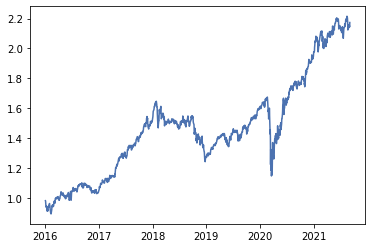

In [432]:
plt.plot((portfolio_daily+1).cumprod())